# Categorising data: supervised and unsupervised learning in Python

Karolina Benkova, Introduction to Python Programming 20-21

In [1]:
!pip install tensorflow

In [2]:
# Display plots inline
%matplotlib inline

# Data libraries
import numpy as np
import sklearn

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ipython interactive widgets
from ipywidgets import interact

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn.neighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

## Data: The MNIST database of handwritten digits 

The dataset we are going to work with consists of a training set of 60,000 and a test set of 10,000 examples of handwritten digits (from 0 to 9). The datasets are pre-processed - each image is size-normalised and stored as a $28 \times 28$ field with the digit positioned in the centre (by computing the centre of mass of the pixels), in greyscale. [1]

In total, we are going to use four files: training set images, training set labels, test set images, and test set labels. We can import these files directly from the `tensorflow` package as numpy arrays of size $\text{# of samples} \times 28 \times 28$, i.e. each row is a $28 \times 28$ matrix (representing an image).

Pixel values (originally in the matrices) represent intensity ranging from 0 (background, white) to 255 (foreground, black). They can be found in the files of training and test set images (here loaded as `numpy` arrays to `X_train_orig`, `X_test_orig`). ('orig' = original dataset)

The labels of the values are 0 to 9, and we will load them into the arrays `Y_train_orig`, `Y_test_orig`.

In [3]:
# Import and load the MNIST datasets
from tensorflow.keras.datasets import mnist
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

For tuning purposes, we split the training data in order to create a validation dataset `X_val` with labels `Y_val`. The validation dataset will contain 10% of the data (i.e. 6,000 samples), while the rest (54,000 samples) will be used for training.

In [4]:
(X_train, X_val, Y_train, Y_val) = sklearn.model_selection.train_test_split(X_train_orig, Y_train_orig, test_size=0.1, random_state=84)

To get an idea about what the images look like and how the writing styles vary, we can plot some of the handwritten digits from the training dataset, along with the corresponding labels.

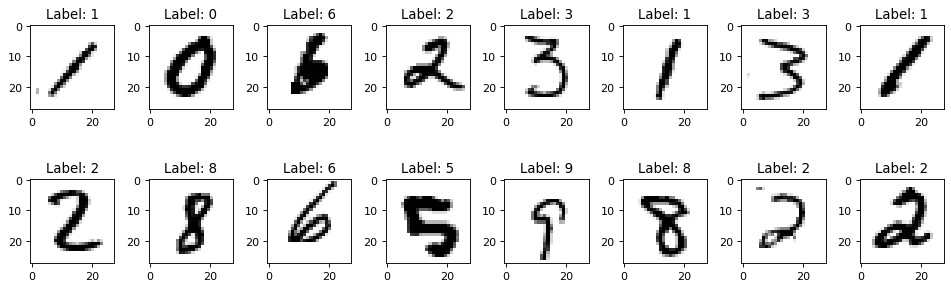

In [5]:
### REFERENCE [2]
images = X_train[:16]
labels = Y_train[:16]
num_row = 2
num_col = 8
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(16):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray_r')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

### END REFERENCE [2]

Given a new, unseen image, our task will be to predict what digit it represents, quickly and accurately enough. This is a classification problem with a total of 10 known classes - digits 0-9.

In order to apply machine learning methods to the data, we will transform the matrices into vectors using the `reshape` function from the `numpy` package. Each image will now be stored as a vector of size $28^2$, and the new data structure will be $\text{# of samples} \times 28^2$ (i.e. 2-dimensional).

In [6]:
pix = 28 # Number of pixels
# Reshape the datasets
X_train = np.reshape(X_train,(X_train.shape[0],pix**2))
X_test = np.reshape(X_test_orig,(X_test_orig.shape[0],pix**2))
X_val = np.reshape(X_val,(X_val.shape[0],pix**2))

## Part I: Supervised learning - Classification

In supervised learning, our goal is to predict the value of an output (in this case, the corect label - the digit) based on a number of inputs (the image as a set of pixels). We use both training data and the correct labels of the outputs.

Given the vector of pixels, we intend to find a pattern represented by the image. In the field of pattern recognition, the aim is to classify the data into given classes. One of such classification alrogithms widely used in pattern recognition is the "*k* Nearest Neighbours" (kNN) method.

The kNN method uses observations from the training set as (training) datapoints, and calculates the distance of a new datapoint, i.e. an unseen image, from the training points. In regression problems, the *k* (predefined number) nearest points can be averaged to get a predicted output, whereas in classification problems, the label is chosen by majority vote, using different weight options to assign weights to the votes. The final label of the output is then picked to be the label with the most total weight. We can also choose how to measure this distance (e.g. Euclidean, Manhattan, Minkowski distance etc.). 

Thus, we have control over 3 parameters: 

 - *k* - the number of neighbours, 

 - the distance function,

 - voting method, i.e. the weights assigned to the labels of the *k* neighbours.

The optimal value of *k* depends on the data. In general, it is said that greater *k* reduces the noise of the data (e.g. blurriness of an image), but on the other hand, it makes the decision boundaries to be less distinct (as the probabilities assigned to different labels might level out).

We will use Euclidean distance, as it is considered appropriate for quantitative features.

 
A drawback of this method is the fact that it's unstructured, and therefore not useful for understanding the relationship between the features and the class outcome. However, in our case we are dealing with pixels only, so such information is not that necessary. [3]


The function we will use for implementing the kNN method, `KNeighborsClassifier`, comes from the `sklearn` package. Its parameters give us control over the method:

 - `n_neighbors` - the number of neighbours, labels of which will be taken into consideration when a new data point is presented

 - `weights` - we will experiment with `uniform` (same weight for each of the k neighbours) and `distance`(weight proportional to the inverse of the distance)

 - `algorithm`- we'll leave this option to the default, `auto`, as the best one will be chosen based on the values passed in the `fit` method

 - `metric` = `minkowski` (the Minkowski, or $l_p$,  distance) and `p`$=2$ will specify the Euclidean distance, both are default 


Some useful methods to be used with the `KNeighborsClassifier` are:

 - `fit(X,y)` - in general used to 'fit' or train the model using the training data, in this case it means saving the datapoints with their labels for later use when searching for nearest neighbours
 
 - `predict(X)` - here X is test or validation data, and we plug it into the model to get a predicted label
 
 - `score(X,y)` - returns the mean accuracy on the test or validation data and labels (compares predicted and true labels)

In order to choose an optimal *k*, we can loop over some values of *k* and compare the accuracy achieved, using the `score` function. A wide range of *k*s can be chosen but because of computational time, we will examine the accuracy for $k \in \{1,3,5,7,9\}$.

In [7]:
### REFERENCE [4]
accuracies = []
ks = np.arange(1,10,2) 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in ks:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k, weights = 'uniform')
    model.fit(X_train, Y_train) 
 
    # evaluate the model and update the accuracies list
    score = model.score(X_val, Y_val)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)
### END REFERENCE [4]

k=1, accuracy=97.48%
k=3, accuracy=97.62%
k=5, accuracy=97.28%
k=7, accuracy=97.10%
k=9, accuracy=97.03%


In [8]:
### REFERENCE [4]
# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data (with weights = uniform)" % (ks[i],
    accuracies[i] * 100))
### END REFERENCE [4]

k=3 achieved highest accuracy of 97.62% on validation data (with weights = uniform)


We can now try to repeat this process, setting `weights` = `distance`, to see what accuracy can be achieved and with what number of neighbors.

In [9]:
accuracies = []
 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in ks:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    model.fit(X_train, Y_train) 
 
    # evaluate the model and update the accuracies list
    score = model.score(X_val, Y_val)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

k=1, accuracy=97.48%
k=3, accuracy=97.60%
k=5, accuracy=97.43%
k=7, accuracy=97.18%
k=9, accuracy=97.15%


In [10]:
# find the value of k that has the largest accuracy
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data (with weights = distance)" % (ks[i],
    accuracies[i] * 100))

k=3 achieved highest accuracy of 97.60% on validation data (with weights = distance)


We see that in both cases, $k=$ achieved the highest accuracy, and the one with uniform weights was slightly better. Henceforth, we will set `k = 3` and `weights = 'uniform'` 

We have used the validation set for tuning, i.e. to find a value of the parameter `k` and a voting method. 

Using these attributes, we can apply the model to the test dataset to find predicted values and evaluate the method. To start with, we can (for example) show the first 10 predictions and compare them to the true labels.

In [11]:
# We pick k=3 and set the parameter weights to uniform 

# Fit the final model with the chosen attributes
knn = KNeighborsClassifier(n_neighbors=3, weights = 'uniform')
knn.fit(X_train, Y_train) # Fit on the train set
Y_pred = knn.predict(X_test) # Predict for the test set

# Show the first 10 predictions
print("kNN predictions:")
print(Y_pred[:10])
print("True labels:")
print(Y_test_orig[:10])

kNN predictions:
[7 2 1 0 4 1 4 9 5 9]
True labels:
[7 2 1 0 4 1 4 9 5 9]


We notice that all of the first 10 labels were predicted correctly!

To see a bigger picture, we can take a look at the classification report and confusion matrix of the model we created. 

The classification report shows us a more complex evaluation of how the model performs by taking into consideration false/true negatives/positives, not only accuracy, therefore we could have also optimise over these metrics to pick *k* (with the validation dataset).

The confusion matrix provides us with information on how the unseen data was (mis)classified. The diagonal elements tell us the number of elements where the predicted label matches the true label. The x-axis shows predicted labels and the y-axis the true labels. Showing and/or plotting the matrix can give us insight on what digits were confused by the model the most.

In [12]:
# Calculate the classification report
digits = np.arange(0,10,1) # Create the labels 
print(sklearn.metrics.classification_report(Y_test_orig, Y_pred,labels=digits))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.99      0.99      0.99       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Confusion matrix as number of classifications: 
 [[ 975    1    1    0    0    1    1    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  10    8  996    3    0    0    0   13    2    0]
 [   0    2    3  978    1   13    1    7    2    3]
 [   2    5    0    0  946    0    4    2    0   23]
 [   5    1    0   14    2  857    4    1    3    5]
 [   5    3    0    0    3    3  944    0    0    0]
 [   0   20    5    0    1    0    0  992    0   10]
 [   9    2    6   14    9   11    3    6  911    3]
 [   4    6    2    9   10    1    1    8    2  966]]


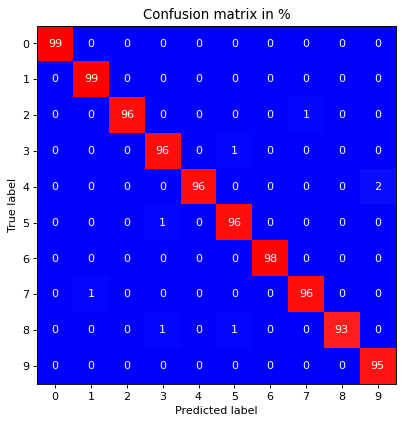

In [13]:
# Create and plot the confusion matrix:
mat = sklearn.metrics.confusion_matrix(Y_test_orig, Y_pred, labels=digits) 
print("Confusion matrix as number of classifications: \n", mat)

# Create a confusion matrix with % 
for i in range(10):
    # We divide each number in a row by the sum of the elements in the row
    # since it represents the true labels (the number of digits in each category)
    mat[i,:] = mat[i,:] / sum(mat[i,:]) *100

### REFERENCE [5]
fig, ax = plt.subplots()
im = ax.imshow(mat,cmap='bwr')

# Show all ticks
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

# Loop over data dimensions and create text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, mat[i, j],ha="center", va="center", color="w")

fig.tight_layout()
### END REFERENCE [5]

ax.set_title("Confusion matrix in %")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

## Part II: Unsupervised learning - Clustering

In unsupervised learning, there is no measure for the outcome. The goal of the algorithms is to find a pattern among the data among the set of inputs, we therefore do not use the labels of the training data. Finding these patterns can be done by cluster analysis, or data segmentation. Its goal is to group the objects (in our case the images) into clusters, such that those in the same cluster are more closely related to each other than to samples in the other clusters. 

An important detail when intending to apply cluster analysis to our data is the measure of the degree of (dis)similarity between the objects we want to cluster. This is captured in the proximity matrix, which can be subsequently used as an input to a clustering algorithm. In the matrix, the values of proximity can be found between pairs of datapoints. The matrix has zeros on its diagonal (i.e. zero distance of the datapoint to itself) and is symmetric, with size $N \times N$ where $N$ is the number of objects we're clustering.

One of the most popular methods in unsupervised learning is the iterative "K-Means" algorithm. It is intended for situations where all features are quantitative, therefore we can apply it to our model as we are dealing with values representing intensities of the pixels. Square Euclidean distance is used as the dissimilarity measure to create the (dissimilarity) proximity matrix. The algorithm itself performs segmentations of the data by assigning the $N$ observations to $K$ clusters such that the average dissimilarity of objects from the cluster mean is minimised (so called "inertia", or within-cluster sum-of-squares). [3]

We will implement this algorithm using the function `KMeans` from `sklearn.cluster`. The algorithm requires the number of clusters, `n_clusters`, to be specified. Since we know how many digits to expect, we can set this to 10, however, it might be interesting to experiment with larger or smaller values and see how the digits get sorted into clusters based on their similarity (we might for example expect the numbers 3 and 8 to be in the same cluster). The parameter `init` by default initialises the cluster centers in a way that speeds up convergence. The maximum number of iterations, `max_iter`, can be adjusted as well, we'll keep the default 300 iterations.


In [14]:
# Recreate the full X_train dataset
X_train = np.reshape(X_train_orig,(X_train_orig.shape[0],pix**2))

We can try this process with both `X_train` and `X_test` datasets to see if the number of samples has an impact on the predictions.

First we define a helper function for showing first 10 images out of each cluster. Then we use the dataset `X_train` to create the clusters, and plot images from each of the 10 clusters.

In [15]:
def show_clusters(model,df,num_clus):
    '''
    This function finds indices of the images in cluster c for c \in {0,1,...,9} using a dataset df
    and plots 10 images from the cluster.

    '''
#     clus = df[model.labels_ == c]

#     images = clus[:10]
    num_col = 10
    # plot images
    
    # loop over plotting rows (different clusters)
    for c in range(num_clus):
        clus = df[model.labels_ == c]
        images = clus[:10]
        print('Images in cluster {}'.format(c))
        fig, axes = plt.subplots(1, num_col, figsize=(1.5*num_col,2*num_row))

        # loop over columns
        for i in range(10):
            ax = axes[i%num_col]
            #print(c)
            ax.imshow(images[i], cmap='gray_r')
        plt.tight_layout()
        plt.show()
    

In [16]:
km10 = KMeans(n_clusters=10, random_state=0).fit(X_train)
km10.predict(X_train)

array([8, 2, 9, ..., 8, 5, 7], dtype=int32)

Images in cluster 0


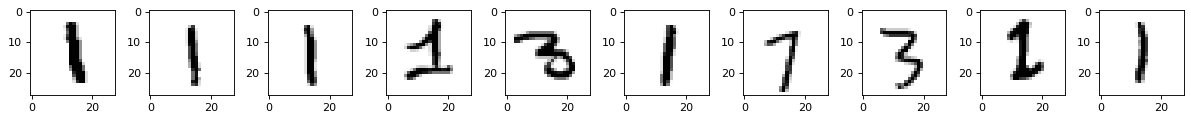

Images in cluster 1


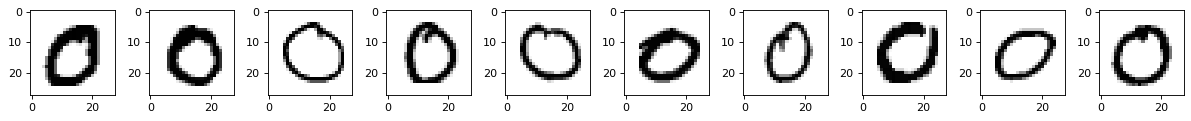

Images in cluster 2


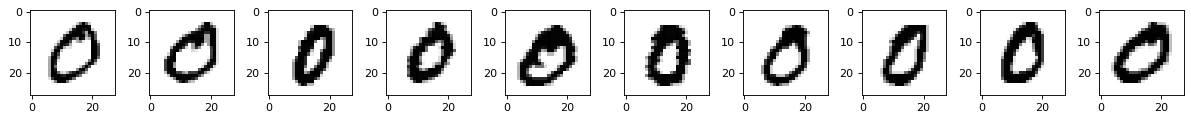

Images in cluster 3


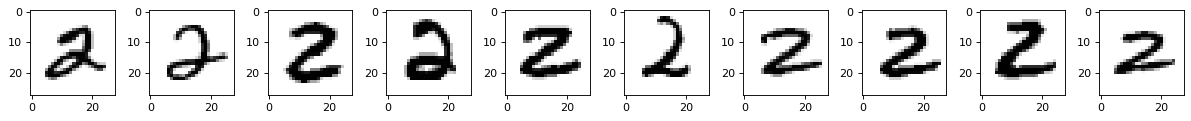

Images in cluster 4


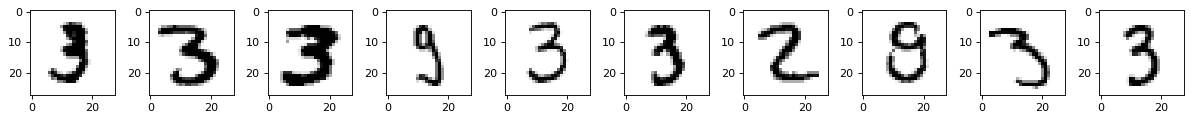

Images in cluster 5


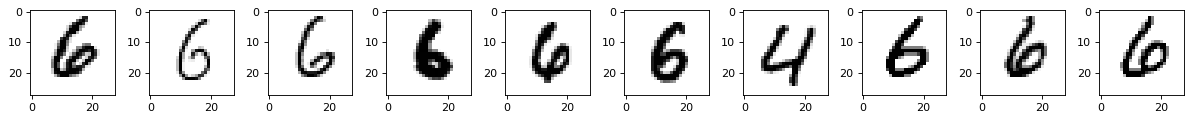

Images in cluster 6


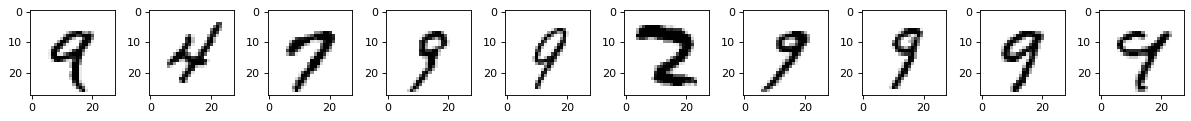

Images in cluster 7


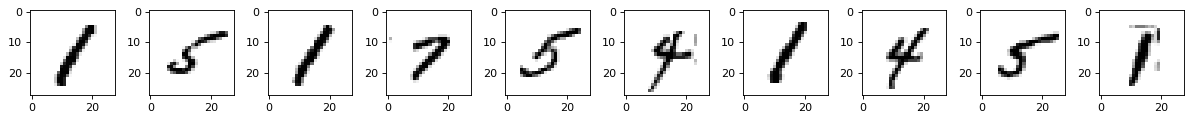

Images in cluster 8


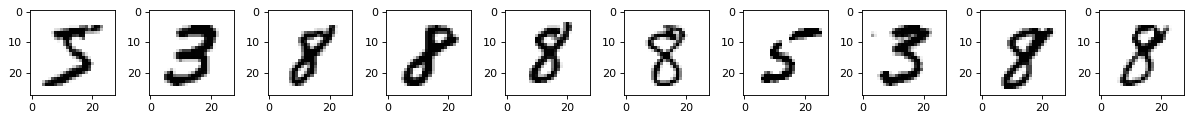

Images in cluster 9


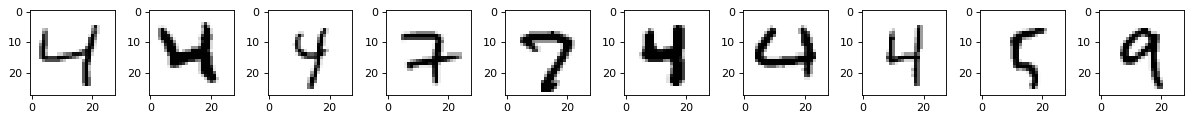

In [17]:
show_clusters(km10,X_train_orig,10)

We can see that some of the clusters show straightforwardly one particular digit. Clusters 1 and 2 both represent different writing styles of 0s. In clusters 0 and 7, 1s are confused with either 3s or 4s and 5s. In cluster 9, 4s get confused with 7s and it's not certain which of these digits dominate in the group. The majority of the samples shown in cluster 6 are 9s, and the clusters 3 and 5 show nicely 2s and 6s, respectively.

We can now try to do the same thing with the dataset `X_test`, which contains 6 times less samples.

In [18]:
km10 = KMeans(n_clusters=10, random_state=0).fit(X_test)
km10.predict(X_test)

array([1, 5, 3, ..., 1, 1, 7], dtype=int32)

Images in cluster 0


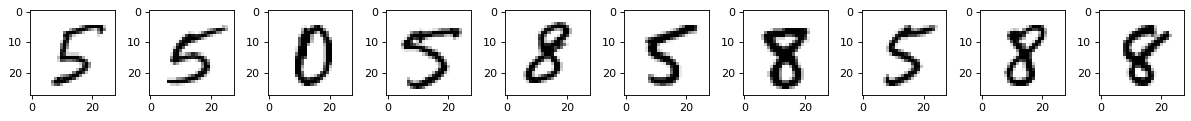

Images in cluster 1


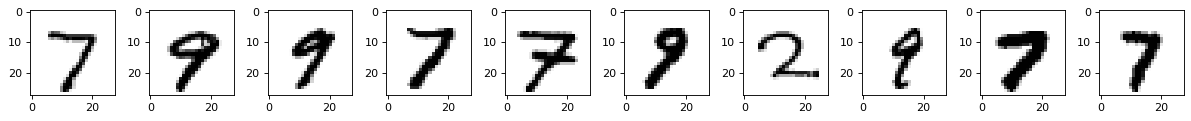

Images in cluster 2


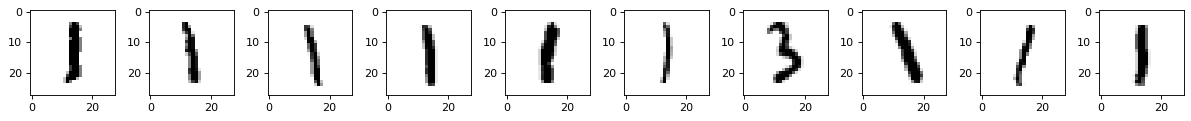

Images in cluster 3


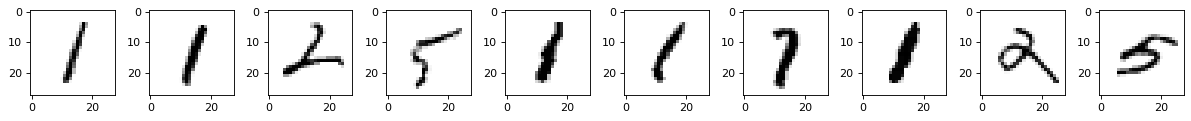

Images in cluster 4


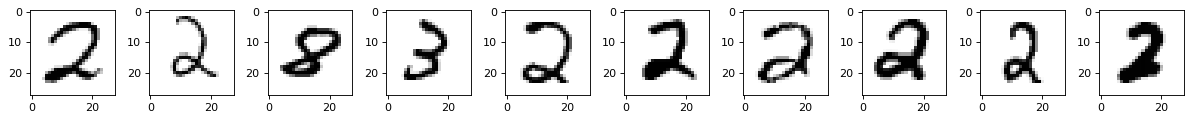

Images in cluster 5


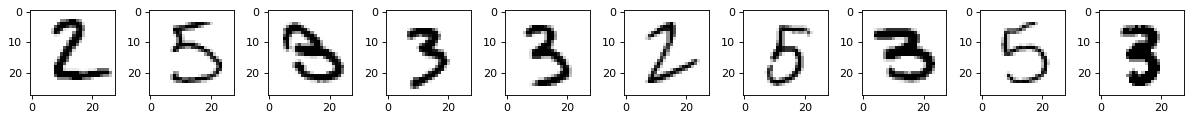

Images in cluster 6


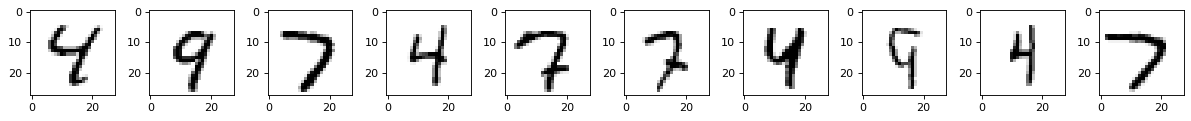

Images in cluster 7


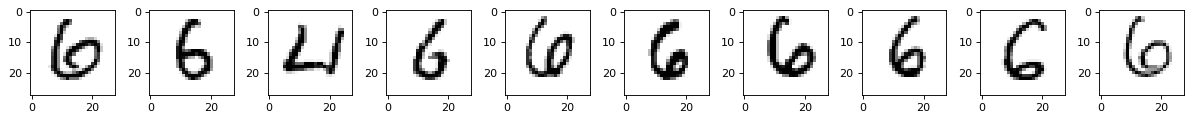

Images in cluster 8


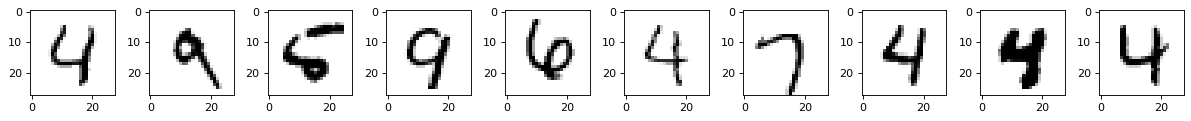

Images in cluster 9


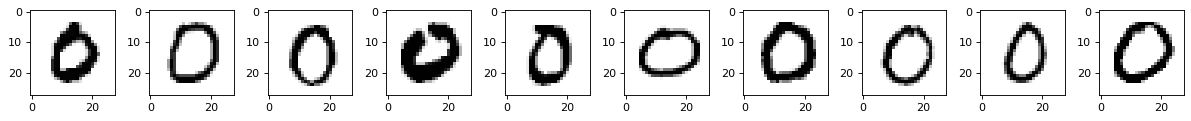

In [19]:
show_clusters(km10,X_test_orig,10)

In this case, we can identify some well grouped images as well: 0s in cluster 9, 6s in cluster 7, 2s in cluster 4, and 1s in cluster 2. We can notice that some 4s and 7s were grouped together, and the model failed distinguishing 5s and 8s as well.

Since some digits (0s in the `X_train` example, 1s in this one) dominate more clusters because of possible different writing styles, it might be worth to increase the number of clusters in the future and run the model again - we can try to re-fit the `X_test` model with 12 clusters.

In [20]:
km12 = KMeans(n_clusters=12, random_state=0).fit(X_test)
km12.predict(X_test)

array([ 9,  5, 10, ...,  0,  0,  7], dtype=int32)

Images in cluster 0


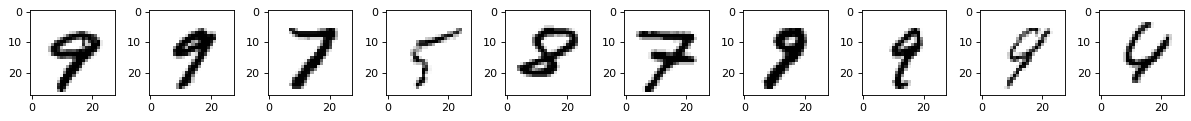

Images in cluster 1


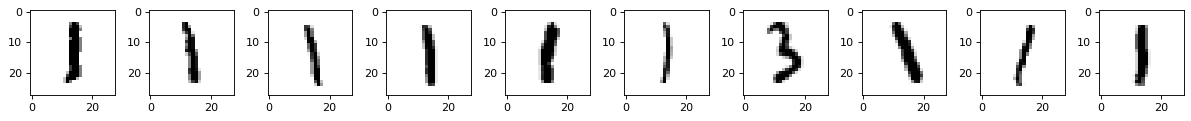

Images in cluster 2


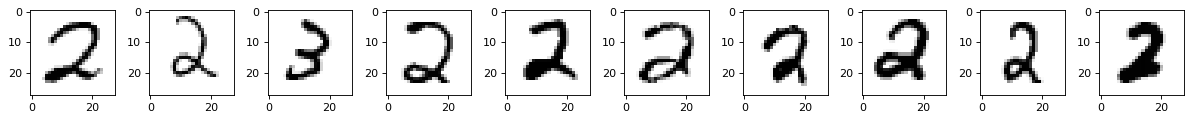

Images in cluster 3


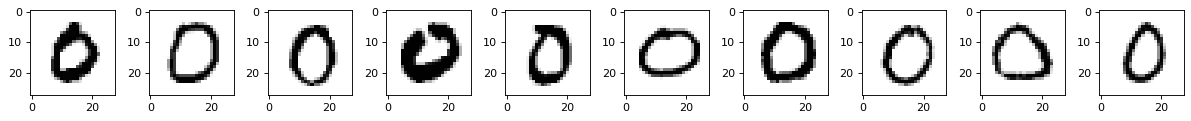

Images in cluster 4


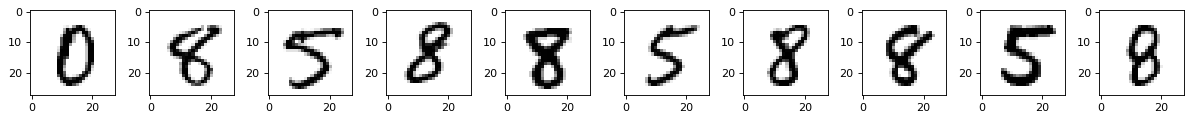

Images in cluster 5


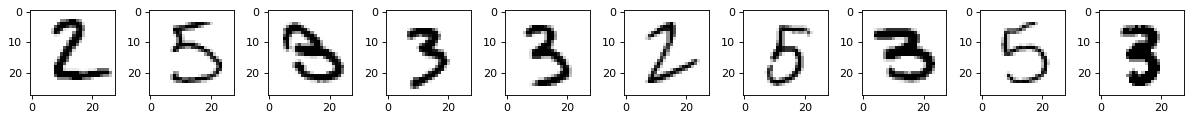

Images in cluster 6


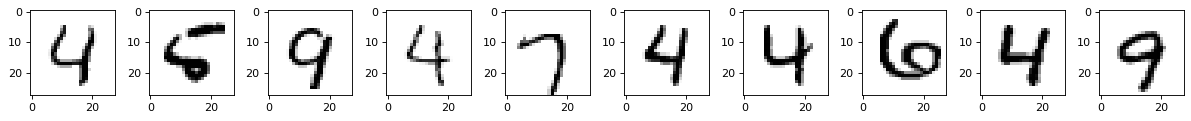

Images in cluster 7


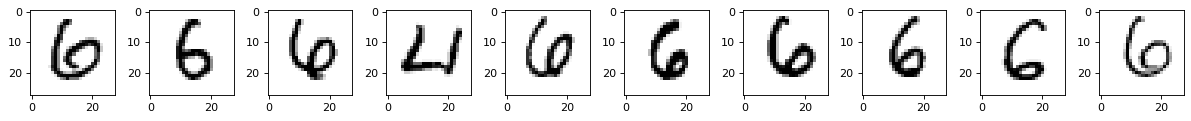

Images in cluster 8


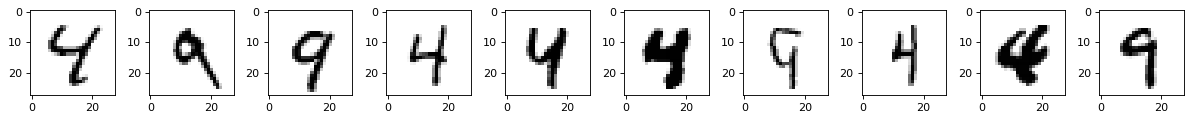

Images in cluster 9


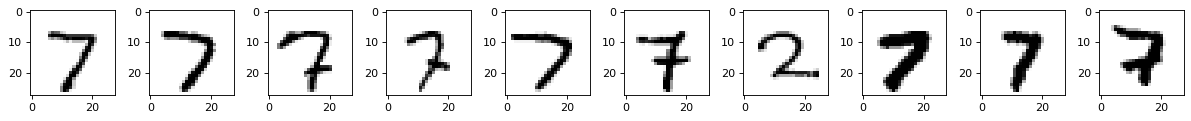

Images in cluster 10


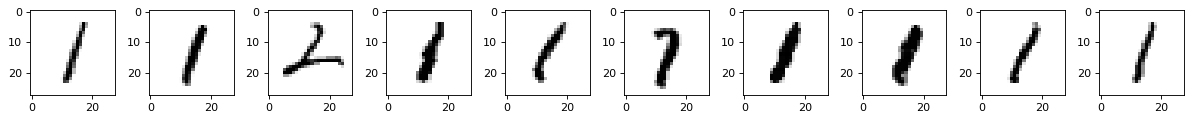

Images in cluster 11


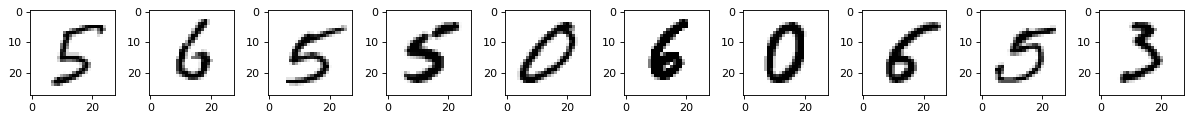

In [21]:
show_clusters(km12,X_test_orig,12)

We can notice an improved grouping of 5s, 3s and 7s, while some of the other digits (like 9s and 4s) still sometimes get confused.

It's difficult to quantify the accuracy of this method as we cannot really assign a label (digit) to each cluster - for some clusters we cannot tell what digit dominates in the group.

In conclusion, when choosing a model for pattern recognition, we need to take into account both computational cost and accuracy, and assign an importance to each one of them. The kNN method achieved >97% in accuracy, however, the computation took quite long time. Meanwhile, the k-Means method took only seconds to compute, but its results are concerning for some of the digits.

### Resources

[1]  [The MNIST dataset](http://yann.lecun.com/exdb/mnist/)

[2]  [How To Plot MNIST Digits Using Matplotlib](https://medium.com/@mrdatascience/how-to-plot-mnist-digits-using-matplotlib-65a2e0cc068)

[3]  [*Elements of Statistical Learning*, by Hastie, Tibshirani, and Friedman](https://web.stanford.edu/~hastie/ElemStatLearn/) 

[4]  [k-Nearest Neighbor classification](https://gurus.pyimagsearch.com/lesson-sample-k-nearest-neighbor-classification/)

[5]  [Creating annotated heatmaps](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html)

(+ information from `sklearn` documentation about the functions used in the project)